In [1]:
# Libraries
from pandas import DataFrame, read_csv, concat
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from matplotlib import pyplot as plt
from numpy import concatenate, reshape
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt
from sklearn.preprocessing import MinMaxScaler
from sys import argv

In [2]:
# Series to Supervised Learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):    
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
    # print("I: ",i)
        cols.append(df.shift(i))
        # print("Column: ",cols)
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
        # print("Names: ",names)
        
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        # print("COls: ",cols)
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
        # print("Names: ",names)

    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    
    return agg

In [3]:
# Read Data and Extract Values
fileName = argv[1]
dataset = read_csv(fileName) 
nrows = dataset.shape[0]
values = dataset.iloc[:,3:].values #Getting values - Total Sentiment and BTC Values
valuesSentiment = dataset.iloc[:,3:].values #Getting total sentiment scores only
valuesBTC = dataset.iloc[:,4:].values #Getting vwap scores only

In [4]:
# Scaling
scaler = MinMaxScaler(feature_range = (0,1))
scaler = scaler.fit(values)
scaled = scaler.fit_transform(values)

In [5]:
# Convert Series to Supervised Data
reframed = series_to_supervised(scaled, 1, 1)

# Drop previous sentiment
reframed=reframed.drop(columns=['var1(t-1)'])

#Splitting data into train and test sets
reframedValues = reframed.values


n_train_days = int(0.9*nrows) #90% data is train, 10% test
train = reframedValues[:n_train_days, :]
test = reframedValues[n_train_days+1:nrows, :]

#Assigning inputs and output datasets
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

#Reshaping input to be 3 dimensions (samples, timesteps, features)
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

In [6]:
#Building LSTM Neural Network model
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2]))) #Recurrent Layer

model.add(Dropout(0.4)) #Dropout Layer
model.add(Dense(15, activation = 'tanh')) #Fully Connected Layer
model.add(Dense(1, activation = 'sigmoid')) #Output Layer
model.compile(loss='mae', optimizer= 'adam', metrics=['acc']) #Compiling the model

# Uncoomen below line to get summary of the model
# print(model.summary(line_length=None, positions=None, print_fn=None))


#Fitting model
history = model.fit(train_X, train_y, epochs = 200, batch_size=25, validation_data=(test_X, test_y), verbose=2, shuffle=False) #Best so far: 100 neurons, epochs = 400, batch_size = 53
print(history.history)

Epoch 1/200
87/87 - 1s - loss: 0.2541 - acc: 4.6339e-04 - val_loss: 0.6341 - val_acc: 0.0000e+00
Epoch 2/200
87/87 - 0s - loss: 0.1381 - acc: 4.6339e-04 - val_loss: 0.6198 - val_acc: 0.0000e+00
Epoch 3/200
87/87 - 0s - loss: 0.1273 - acc: 4.6339e-04 - val_loss: 0.5874 - val_acc: 0.0000e+00
Epoch 4/200
87/87 - 0s - loss: 0.1198 - acc: 4.6339e-04 - val_loss: 0.5441 - val_acc: 0.0000e+00
Epoch 5/200
87/87 - 0s - loss: 0.1100 - acc: 4.6339e-04 - val_loss: 0.4719 - val_acc: 0.0000e+00
Epoch 6/200
87/87 - 0s - loss: 0.1024 - acc: 4.6339e-04 - val_loss: 0.3704 - val_acc: 0.0042
Epoch 7/200
87/87 - 0s - loss: 0.0896 - acc: 4.6339e-04 - val_loss: 0.2177 - val_acc: 0.0042
Epoch 8/200
87/87 - 0s - loss: 0.0733 - acc: 4.6339e-04 - val_loss: 0.0788 - val_acc: 0.0042
Epoch 9/200
87/87 - 0s - loss: 0.0575 - acc: 4.6339e-04 - val_loss: 0.0713 - val_acc: 0.0042
Epoch 10/200
87/87 - 0s - loss: 0.0401 - acc: 4.6339e-04 - val_loss: 0.0623 - val_acc: 0.0042
Epoch 11/200
87/87 - 0s - loss: 0.0404 - acc: 4.6

87/87 - 0s - loss: 0.0206 - acc: 4.6339e-04 - val_loss: 0.0588 - val_acc: 0.0042
Epoch 89/200
87/87 - 0s - loss: 0.0202 - acc: 4.6339e-04 - val_loss: 0.0677 - val_acc: 0.0042
Epoch 90/200
87/87 - 0s - loss: 0.0206 - acc: 4.6339e-04 - val_loss: 0.0599 - val_acc: 0.0042
Epoch 91/200
87/87 - 0s - loss: 0.0202 - acc: 4.6339e-04 - val_loss: 0.0560 - val_acc: 0.0042
Epoch 92/200
87/87 - 0s - loss: 0.0198 - acc: 4.6339e-04 - val_loss: 0.0619 - val_acc: 0.0042
Epoch 93/200
87/87 - 0s - loss: 0.0199 - acc: 4.6339e-04 - val_loss: 0.0591 - val_acc: 0.0042
Epoch 94/200
87/87 - 0s - loss: 0.0197 - acc: 4.6339e-04 - val_loss: 0.0564 - val_acc: 0.0042
Epoch 95/200
87/87 - 0s - loss: 0.0203 - acc: 4.6339e-04 - val_loss: 0.0553 - val_acc: 0.0042
Epoch 96/200
87/87 - 0s - loss: 0.0200 - acc: 4.6339e-04 - val_loss: 0.0615 - val_acc: 0.0042
Epoch 97/200
87/87 - 0s - loss: 0.0202 - acc: 4.6339e-04 - val_loss: 0.0534 - val_acc: 0.0042
Epoch 98/200
87/87 - 0s - loss: 0.0199 - acc: 4.6339e-04 - val_loss: 0.06

Epoch 175/200
87/87 - 0s - loss: 0.0199 - acc: 4.6339e-04 - val_loss: 0.0687 - val_acc: 0.0042
Epoch 176/200
87/87 - 0s - loss: 0.0201 - acc: 4.6339e-04 - val_loss: 0.0673 - val_acc: 0.0042
Epoch 177/200
87/87 - 0s - loss: 0.0194 - acc: 4.6339e-04 - val_loss: 0.0617 - val_acc: 0.0042
Epoch 178/200
87/87 - 0s - loss: 0.0194 - acc: 4.6339e-04 - val_loss: 0.0609 - val_acc: 0.0042
Epoch 179/200
87/87 - 0s - loss: 0.0207 - acc: 4.6339e-04 - val_loss: 0.0677 - val_acc: 0.0042
Epoch 180/200
87/87 - 0s - loss: 0.0196 - acc: 4.6339e-04 - val_loss: 0.0542 - val_acc: 0.0042
Epoch 181/200
87/87 - 0s - loss: 0.0192 - acc: 4.6339e-04 - val_loss: 0.0612 - val_acc: 0.0042
Epoch 182/200
87/87 - 0s - loss: 0.0195 - acc: 4.6339e-04 - val_loss: 0.0683 - val_acc: 0.0042
Epoch 183/200
87/87 - 0s - loss: 0.0192 - acc: 4.6339e-04 - val_loss: 0.0620 - val_acc: 0.0042
Epoch 184/200
87/87 - 0s - loss: 0.0200 - acc: 4.6339e-04 - val_loss: 0.0575 - val_acc: 0.0042
Epoch 185/200
87/87 - 0s - loss: 0.0189 - acc: 4.6

In [7]:
# Predicition
model_prediction = model.predict(test_X)

In [8]:
# Reshae Test_X
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

In [9]:
# BTC Value Scaling
scalerBTC = MinMaxScaler(feature_range = (0,1))
scalerBTC = scaler.fit(values)
scaledBTC = scaler.fit_transform(values)

In [10]:
# Inverse Scale
scaler = MinMaxScaler(feature_range = (0,1))
scaler = scaler.fit(valuesBTC)
model_prediction_unscale = scaler.inverse_transform(model_prediction)

predictedValues = reshape(model_prediction_unscale, model_prediction_unscale.shape[0])
actualValues = valuesBTC[n_train_days+1:]
actualValues = reshape(actualValues, actualValues.shape[0])

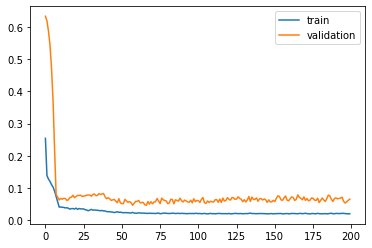

In [11]:
#Plotting training loss vs validation loss
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.show()

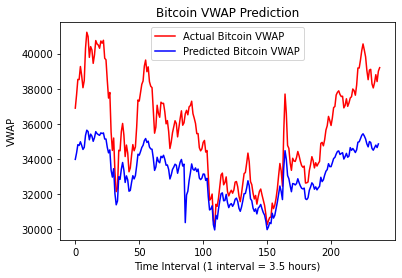

In [12]:
#Visualising Results (Actual vs Predicted)
plt.plot(actualValues, color = 'red', label = 'Actual Bitcoin VWAP')
plt.plot(predictedValues, color = 'blue', label = 'Predicted Bitcoin VWAP') #[1:38]
plt.title('Bitcoin VWAP Prediction')
plt.xlabel('Time Interval (1 interval = 3.5 hours)')
plt.ylabel('VWAP')
plt.legend()

# Uncomment below line to save the figure
# plt.savefig('Trend Graph.png', dpi=700)

plt.show()

In [13]:
actual= DataFrame(actualValues, columns= ['Actual Value'])
predicted=DataFrame(predictedValues, columns= ['Predicted Value'])

In [14]:
#Calculating RMSE and MAE
errorDF=concat([actual,predicted], axis=1)
errorDF.dropna(inplace=True)
rmse = sqrt(mean_squared_error(errorDF.iloc[:,0], errorDF.iloc[:,1]))
mae = mean_absolute_error(errorDF.iloc[:,0], errorDF.iloc[:,1])
print('Test MAE: %.3f' % mae)
print('Test RMSE: %.3f' % rmse)

Test MAE: 2348.986
Test RMSE: 2739.352


In [15]:
# Write to csv
timestamp = DataFrame(dataset['timestamp'][n_train_days:], columns= ['timestamp'])
timestamp.reset_index(drop=True, inplace=True)
results=concat([timestamp,actual,predicted], axis=1)
results.dropna(inplace=True)
results.to_csv("Results - withSentiment.csv", index= False)